In [43]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch

from src import datasets, metrics

In [46]:
import tomllib

datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [47]:
trainfile = datadir / (config['arrhythmia'] + '_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

Get the 1D data into a 2D matrix

In [51]:
shape = (16, 12)
traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
traindataset, testdataset
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
else:
    device = "cpu"


In [52]:
from collections import defaultdict
import torch
import random
from torch.utils.data import TensorDataset

# Zet random seed voor reproduceerbaarheid
random.seed(42)
torch.manual_seed(42)

# Verdeel data per klasse
class_samples = defaultdict(list)
for x, y in traindataset:
    class_samples[y.item()].append(x)

balanced_data = []
balanced_labels = []

samples_per_class = 5000  # We willen totaal 25000 samples, dus 5000 per klasse

for class_label in range(5):  # Klassen: 0 t/m 4
    samples = class_samples[class_label]
    num_samples = len(samples)

    if num_samples > samples_per_class:
        # Downsampling
        selected = random.sample(samples, samples_per_class)
    else:
        # Upsampling met vervanging
        selected = random.choices(samples, k=samples_per_class)

    balanced_data.extend(selected)
    balanced_labels.extend([class_label] * samples_per_class)

# Shuffle de gecombineerde data
combined = list(zip(balanced_data, balanced_labels))
random.shuffle(combined)

# Zet om naar tensors
X_balanced = torch.stack([x for x, _ in combined])
y_balanced = torch.tensor([y for _, y in combined])

# Maak nieuwe dataset
balanced_dataset = TensorDataset(X_balanced, y_balanced)

print(f"Nieuwe datasetgrootte: {len(balanced_dataset)} samples")


Nieuwe datasetgrootte: 25000 samples


Let's see how that works. 
Compare this to the 1D data to see if you understand the transformation.

(torch.Size([1, 16, 12]), tensor(0))

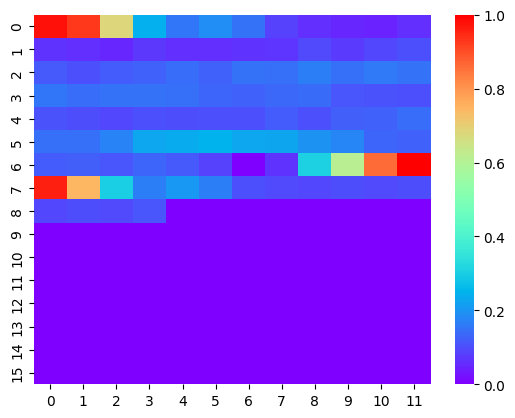

In [ ]:
x, y = traindataset[0]
viz = x.squeeze().cpu().numpy()
sns.heatmap(viz, cmap='rainbow')
x.shape, y

(torch.Size([1, 16, 12]), tensor(4))

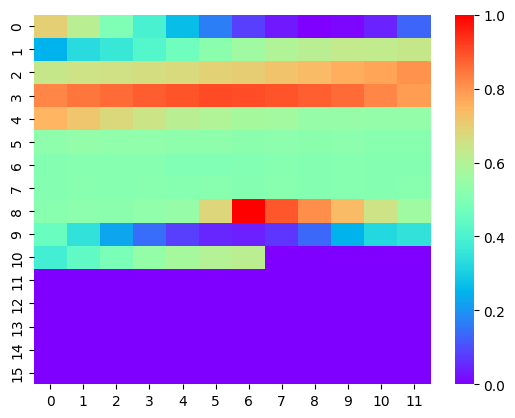

In [ ]:
x, y = balanced_dataset[4]
viz = x.squeeze().cpu().numpy()
sns.heatmap(viz, cmap='rainbow')
x.shape, y

Load into a streamer

In [54]:
trainstreamer = BaseDatastreamer(balanced_dataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(781, 684)

In [55]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 1, 16, 12]), torch.Size([32]))

`mltrainer` provides a ConvBlock, which makes it easier to stack block in the model.
It also provides an architecture inspired by AlexNet (2012) which is used as a starting point for image classification.

Feel free to experiment with other architectures here:
- adding ideas like resnet, googlenet, squeeze-excite, or even vision transformers (eg see [torch docs](https://docs.pytorch.org/tutorials/beginner/vt_tutorial.html#classifying-images-with-deit) ) 
- add additional layers like dropout, batchnorm, etc.
- experiment with different ways to go from 4D to 2D tensors

In [56]:
from mltrainer.imagemodels import CNNConfig, CNNblocks

In [99]:
config = CNNConfig(
    matrixshape=shape,
    batchsize=32,
    input_channels=1,
    hidden=32,
    kernel_size=3,
    maxpool=2,
    num_layers=3,
    num_classes=5,
)
model = CNNblocks(config)
model(x).shape

Calculated matrix size: 12
Caluclated flatten size: 384


torch.Size([32, 5])

In [93]:
yhat = model(x)

The data is unbalanced, so we are interested in much more than just accuracy.

In [94]:
config.__dict__

{'matrixshape': (16, 12),
 'batchsize': 32,
 'input_channels': 1,
 'hidden': 32,
 'kernel_size': 3,
 'maxpool': 1,
 'num_layers': 5,
 'num_classes': 5}

Read [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) about micro and macro F1 scores.


In [95]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [96]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam_2D_explore.db")
mlflow.set_experiment("2D alexnet")

<Experiment: artifact_location='/home/azureuser/MADS-exam-25/notebooks_adriaan/mlruns/1', creation_time=1750254204739, experiment_id='1', last_update_time=1750254204739, lifecycle_stage='active', name='2D alexnet', tags={}>

In [97]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=10,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5,
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Conv2D")
    mlflow.set_tag("dataset", "heart_small_binary")
    mlflow.set_tag("layers", "5")
    mlflow.set_tag("filters", "32")
    mlflow.set_tag("kernel", "3")
    mlflow.set_tag("batch size", "32")
    mlflow.set_tag("optimizer", "Adam")
    mlflow.set_tag("activation", "ReLU")
    mlflow.set_tag("dropout", "no")
    mlflow.set_tag("batch norm", "no")
    mlflow.set_tag("epochs", "10")
    mlflow.set_tag("early stopping", "no")
    mlflow.set_tag("learning rate", "0.001")
    mlflow.set_tag("scheduler", "no")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config.__dict__)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("shape0", shape[0])
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()


2025-06-18 15:18:32.536 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to logs/heart2D/20250618-151832
100%|██████████| 156/156 [00:07<00:00, 20.66it/s]
2025-06-18 15:18:43.859 | INFO     | mltrainer.trainer:report:209 - Epoch 0 train 1.6117 test 1.6096 metric ['0.0255', '0.0255', '0.0124', '0.0255', '0.1522']
100%|██████████| 156/156 [00:07<00:00, 20.36it/s]
2025-06-18 15:18:55.225 | INFO     | mltrainer.trainer:report:209 - Epoch 1 train 1.6103 test 1.6348 metric ['0.0673', '0.0673', '0.0347', '0.0673', '0.2526']
100%|██████████| 156/156 [00:11<00:00, 13.04it/s]
2025-06-18 15:19:10.807 | INFO     | mltrainer.trainer:report:209 - Epoch 2 train 1.6100 test 1.5964 metric ['0.0648', '0.0648', '0.0334', '0.0648', '0.2499']
100%|██████████| 156/156 [00:31<00:00,  4.90it/s]
2025-06-18 15:19:46.236 | INFO     | mltrainer.trainer:report:209 - Epoch 3 train 1.6103 test 1.5874 metric ['0.8336', '0.8336', '0.2683', '0.8336', '0.2935']
100%|██████████| 156/156 [00:43<00:00,  3.57it

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

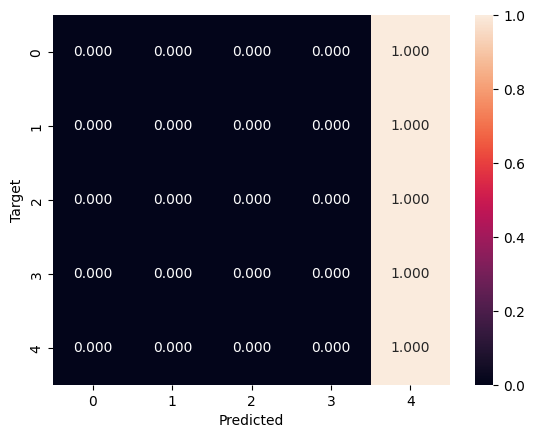

In [98]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")